# Covid19 fakenews detection using NLP

![separator](files/sep.jpeg)

One of the sharde tasks of CONSTRAINT 2021's first Workshop on Combating Online Hostile Posts in Regional Languages during Emergency Si​tuation, was about  "*Fighting an Infodemic: COVID-19 Fake News*". Here is my modest participation at the Codalab's competition [COVID19 Fake News Detection in English](https://competitions.codalab.org/competitions/26655#learn_the_details)

The [Fighting an Infodemic: COVID-19 Fake News Dataset](https://arxiv.org/abs/2011.03327) contains tweets along with their associated binary
labels: `real` for real/verified COVID19 related informations and `fake` for hoaxes/fake news. I used Natural Language Processing to perform a binary classification, and train a model to guess the real from the fake tweets.

We proceed as follow:

* **Data analysis** - We prepare, study and explore a dataset, highliting important correlations.
* **Model modelling** - we create and train a model to predict our label variable, then we tune the hyper-parameters of our model in order to improve it if possible.
* **Model evaluation and comparison** - we evaluate it using some metrics and compare them to find the best one.  
* **Conclusion/further contributions**.

To work through these topics, we'll use the `scikit learn` API and the models from SVM, LogisticRegression, XGBoost and Naive Bayes.

In [4]:
# Data analysis libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import collections

## Scikit Learn Models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

## Feature extraction
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words


## text preprocessing
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import string
#import emoji


## Scikit Learn Model evaluators:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion

## Check for GPU
#print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available...")

For visibility reasons, I will use the following set of colours : 
<span style="color:#dce9f2">#dce9f2</span>, <span style='color:#b5cce3'>#b5cce3</span>, <span style='color:#8c95c6'>#8c95c6</span>, <span style='color:#894da3'>#894da3</span> and <span style='color:#6a0867'>#6a0867</span> 


In [ ]:
## Seaborn grid style
plt.style.use('seaborn-whitegrid')

#sns.heatmap(np.linspace(1,5,15).reshape(5,3), cmap='BuPu');
colours = [ '#dce9f2', '#b5cce3', '#8c95c6', '#894da3', '#6a0867']

Here are some useful functions that we will be using all along:

In [ ]:
# Plots a more visual confusion matrix
def conf_mtrx_plot(mtrx, normalize=False) :
    """ Plot confusion matrix using seaborn's heatmap """
    if normalize:
      mtrx = mtrx.astype('float') / mtrx.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax = sns.heatmap(data = mtrx,
                     cmap = 'BuPu',
                     #fmt = '.2f',
                     robust = True,
                     center = 0,
                     square = True,
                     annot = True)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    return fig

# Plots a more visual ROC curve
def ROC_cur_plot(clf, X_test, y_test):
    ''' Plot a ROC curve of the TPR and FPR'''
    fig, ax = plt.subplots(figsize = (8,8))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    AUC = metrics.auc(fpr,tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colours[2], label='AUC: {:.2f}'.format(AUC))
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color=colours[4], linestyle='--', label='Guess')
    # Customize the plot
    plt.xlabel('False Positive Rate (fpr)')
    plt.ylabel('True Positive Rate (tpr)')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.style.use('default')
    return fig

# 1) Data analysis:

The original dataset is from the [Codalab](https://competitions.codalab.org/competitions/26655#learn_the_details). It contains 8560 tweets split into a training and validation sets, and a testing set of 2140 tweets to label.

### Data description: 

We import our csv files:

In [ ]:
train_df = pd.read_csv('files/Constraint_English_Train - Sheet1.csv', index_col = 'id',)
val_df = pd.read_csv('files/Constraint_English_Val - Sheet1.csv', index_col = 'id')
test_df = pd.read_csv('files/english_test_with_labels - Sheet1.csv', index_col = 'id')

main_df = pd.concat([train_df, val_df]).sample(frac=1).reset_index(drop=True)

Our data is in the form of a DataFrame of $8560$ tweets with the labels `real` for real news and `fake` for the fake ones:

In [ ]:
main_df.head()

,tweet,label
0,"Nancy Pelosi said, ???if you accept a check fr...",fake
1,RT @CDCHeart_Stroke: #HeartAttacks and #stroke...,real
2,The SARS-CoV-2 has been engineered by man edit...,fake
3,We expect to complete this by the end of the d...,real
4,RT @PIB_India: Cases per million population in...,real


In [ ]:
main_df['label'].unique()

array(['fake', 'real'], dtype=object)

In [ ]:
main_df.shape

(8560, 2)

**NOTE :** here is a personnal favourite:

In [ ]:
val_df['tweet'].iloc[0]

'Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country'

We can see how the reviews are reparted:

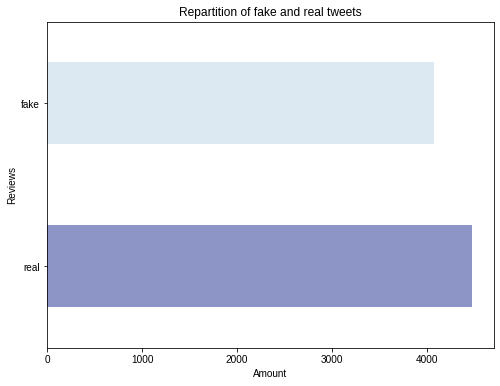

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
main_df.label.value_counts().plot(kind = 'barh',
                                    color=(colours[2], colours[0]),
                                    ax = ax)

plt.title('Repartition of fake and real tweets')
plt.xlabel('Amount')
plt.ylabel('Reviews');

Moreover, we can also perform some statistical analysis on the dataset and get  descriptive statistics in order to process our data:
  
  * count words : number of words in the tweet

In [ ]:
count_words = main_df['tweet'].apply(lambda x: len(re.findall(r'\w+', x)))

main_df['count_words'] = count_words

The number of words used in the tweets is in average lower than 80 words. We also observe that real tweets tend to contain more words than the fake ones.

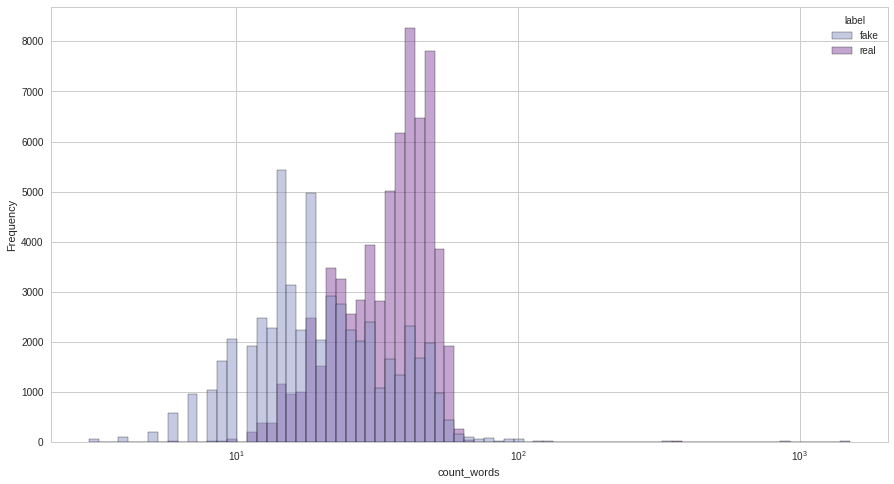

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))

#plot:
sns.histplot(data = main_df,
             x = 'count_words', 
             hue = 'label', 
             stat = 'frequency',
             common_norm=True,
             kde = False,
             log_scale=True,
             palette = (colours[2], colours[3]));

* count mentions : referrals to other Twitter accounts, which are preceded by a `@`


In [ ]:
count_mentions = main_df['tweet'].apply(lambda x: len(re.findall(r'@\w+', x)))

main_df['count_mentions'] = count_mentions

Most of the tweets don't have mentions, and few real ones have one or two.

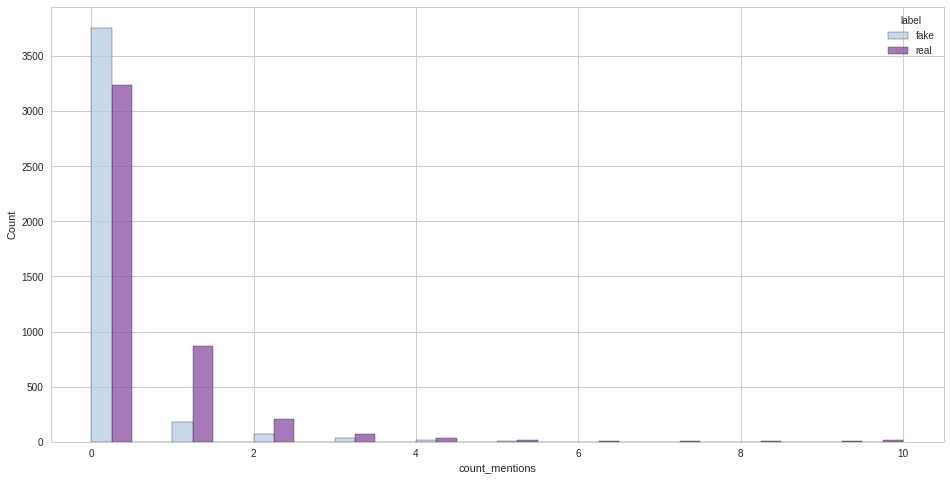

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
sns.histplot(data = main_df[main_df['count_mentions'] <= 10],
             x = 'count_mentions', 
             hue = 'label', 
             binwidth = .5,
             kde = False,
             multiple="dodge", 
             palette = (colours[1], colours[3]));

* count hashtags : number of tag words, preceded by a #

In [ ]:
count_hashtags = main_df['tweet'].apply(lambda x: len(re.findall(r'#\w+', x)))

main_df['count_hashtags'] = count_hashtags

Most of the tweets do not contain hash tags, and the few that have tend to be real, maybe it can make a difference during training depending on if we get rid of it or not in text processing.

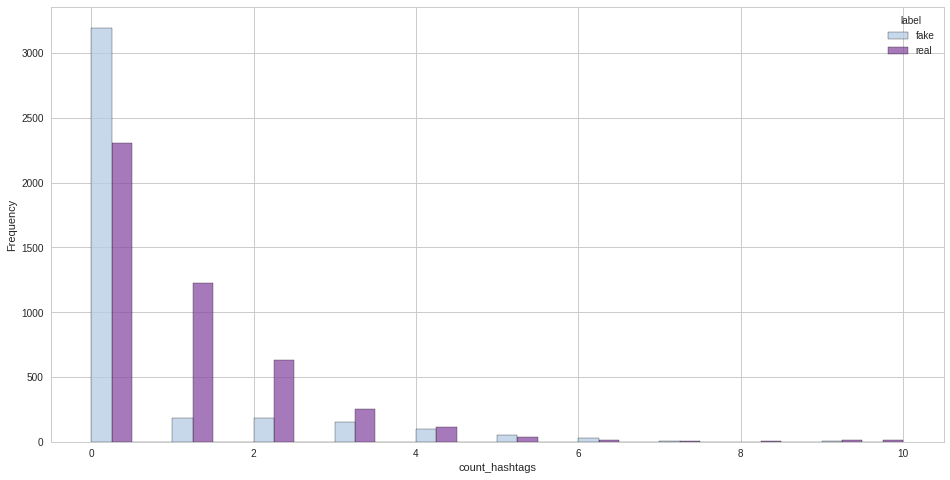

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
sns.histplot(data = main_df[main_df['count_hashtags'] <= 10],
             x = 'count_hashtags', 
             hue = 'label', 
             stat = 'frequency',
             binwidth = .5,
             kde = False,
             multiple="dodge", 
             palette = (colours[1], colours[3]));

* count capital words : number of uppercase words, could be used to somehow "shout accusations" and "denounce conspiracy" 

In [ ]:
count_caps = main_df['tweet'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))

main_df['count_caps'] = count_caps

Most of the tweets do not contain capitalized words and so it probably won't have any effect if we `lower()` our texts.

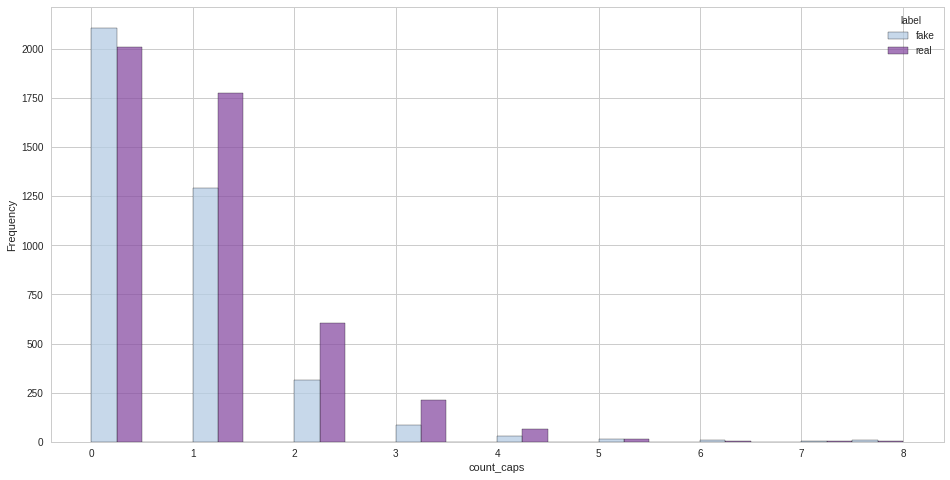

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
sns.histplot(data = main_df[main_df['count_caps'] <= 8],
             x = 'count_caps', 
             hue = 'label', 
             stat = 'frequency',
             binwidth = .5,
             kde = False,
             multiple="dodge", 
             palette = (colours[1], colours[3]));

* count exclamation/question marks : number of question or exclamation marks

In [ ]:
count_excl_quest_marks = main_df['tweet'].apply(lambda x: len(re.findall(r'!|\?', x)))

main_df['count_excl_quest_marks'] = count_excl_quest_marks

The fake tweets seem to be using a bit more exclamation or question marks than the real ones.

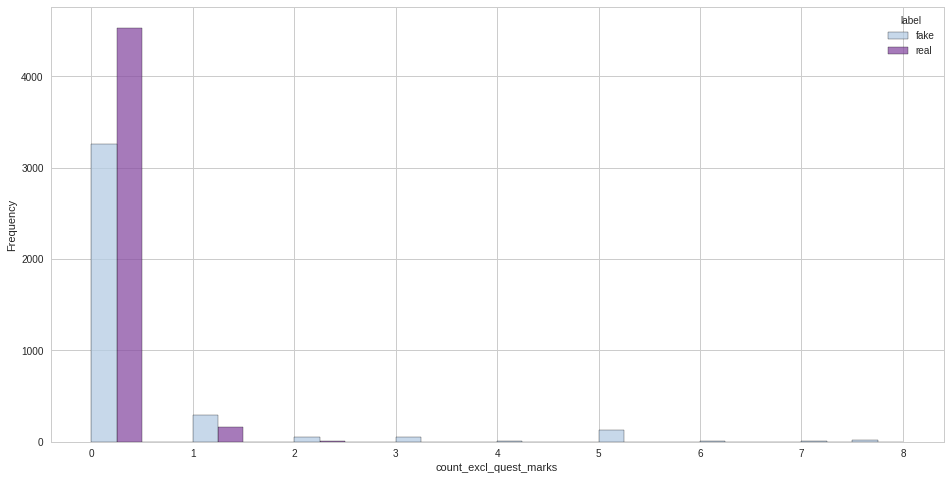

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
sns.histplot(data = main_df[main_df['count_excl_quest_marks'] <= 8],
             x = 'count_excl_quest_marks', 
             hue = 'label', 
             stat = 'frequency',
             binwidth = .5,
             kde = False,
             multiple="dodge", 
             palette = (colours[1], colours[3]));

* count URLs : number of links in the tweet, preceded by http(s), might be a source that can be verified/denied.

In [ ]:
count_urls = main_df['tweet'].apply(lambda x: len(re.findall(r'http.?://[^\s]+[\s]?', x)))

main_df['count_urls'] = count_urls

It seems that more real tweets use URLS than fake ones, which seems a bit logical, maybe taking into account the tweets with verifiable urls might help our classification

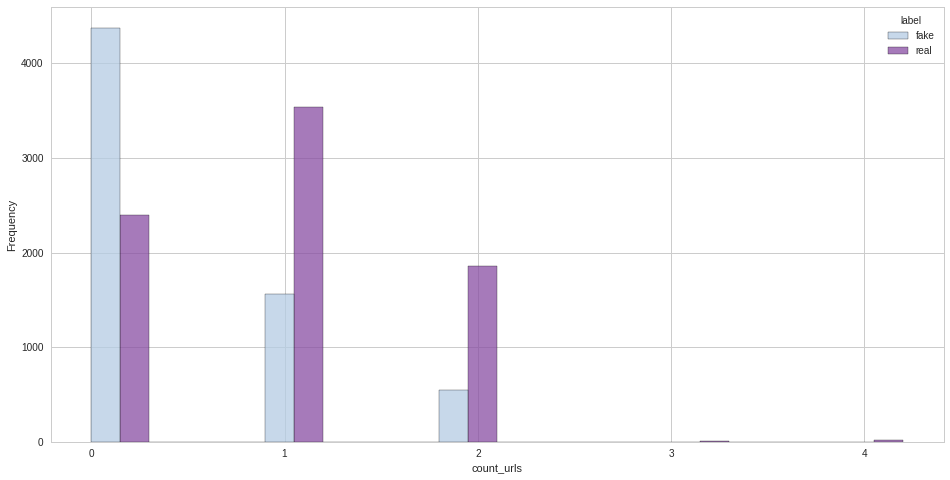

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
sns.histplot(data = main_df[main_df['count_urls'] <= 10],
             x = 'count_urls', 
             hue = 'label', 
             stat = 'frequency',
             binwidth = .3,
             kde = False,
             multiple="dodge", 
             palette = (colours[1], colours[3]));

And finally, we count the number of emojis in each tweet : (we use the module `emoji`)

In [ ]:
count_emojis = main_df['tweet'].apply(lambda x: emoji.demojize(x)).apply(lambda x: len(re.findall(r':[a-z_&]+:', x)))

main_df['count_emojis'] = count_emojis

We can see that quasi all the tweets do not use emojis, hence it would not make that much of a difference to leave them.

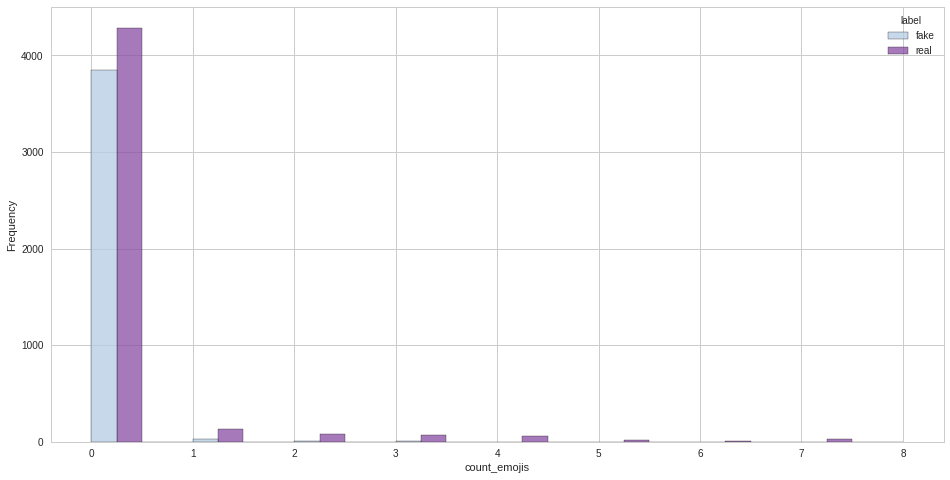

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
sns.histplot(data = main_df[main_df['count_emojis'] <= 8],
             x = 'count_emojis', 
             hue = 'label', 
             stat = 'frequency',
             binwidth = .5,
             kde = False,
             multiple="dodge", 
             palette = (colours[1], colours[3]));

# 2) Data modelling:

Here we will try to build a model and train in order to predict our `label` variable:

## Set up and text processing:

We first convert the class labels into binary numerical variables for convenience:

In [ ]:
main_df['label'] = main_df.label.map({'real':1, 'fake':0})

We preprocess our tweets for a better performance:

In [ ]:
stopwords = stop_words.ENGLISH_STOP_WORDS

def clean(text): 

  """ Takes a string of text and preprocess it, by removing hashtapgs, punctuations, numbers and tokenizing"""
#  text = re.sub(r'@\w+', '', text) # remove mentions 
  text = text.replace("#", "") # remove the hashtag character
  text = text.replace("RT", "") # remove the retweet mention
  text = text.lower() # lowercase
  text = "".join([char for char in text if char not in string.punctuation and not char.isdigit()]) #remove punctuation and numbers
  text = " ".join([token for token in text.split() if token not in stopwords]) 
# porter = PorterStemmer()
# text = " ".join([porter.stem(word) for word in text.split()]) #stemming #it actually works better without

  return text

**NOTE:** There is a nice and elegant library (and also more compact way) for tweet preprocessing in Python: [Preprocessor](https://github.com/s/preprocessor)

Here is an example of how the clean functions works, applied to one of my favourite tweetter accounts:

In [ ]:
text = '@KyloR3n hello @hottopic i want a shirt that says I’m a different person but it should be the same color and basically the same shirt'

clean(text)

'hello want shirt say i’m differ person color basic shirt'

Finally, let us clean our data and regroup everything together:

In [ ]:
clean_tweet = main_df['tweet'].apply(clean)

main_df['clean_tweet'] = clean_tweet

main_df = main_df.drop(['tweet'], axis = 1)

**NOTE:** We make sure that our cleaned tweets have no empty entry:

In [ ]:
np.where(pd.isnull(main_df))

(array([], dtype=int64), array([], dtype=int64))

Now, we can see the distribution of the words per frequency in all the tweets

In [ ]:
vect = CountVectorizer()
bag = vect.fit_transform(clean_tweet)
word_freq = dict(zip(vect.get_feature_names(), np.asarray(bag.sum(axis=0)).ravel()))
word_count = collections.Counter(word_freq)
word_count_df = pd.DataFrame(word_count.most_common(20), columns = ['word', 'frequency'])

We observe that *covid* is obviously the most common word, words like *case*, *test*, *report*, *death* are common as well.

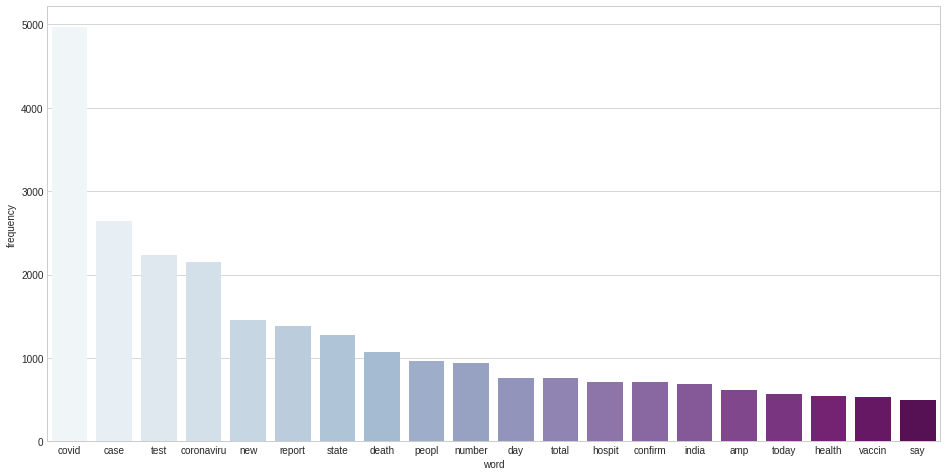

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
bar_freq_word = sns.barplot(x="word", y="frequency", data=word_count_df, palette="BuPu", ax=ax)

## Data modelling:

Our model is about **classification**, where we are predicting a **categorical variable** : `label`. It has **labeled data** of less than 100.000 samples. Using Scikit Learn's [documentation](https://scikit-learn.org/stable/user_guide.html) we opt for the following models:

* Log Reg : [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* MultinomialNB : [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* Linear SVC : [Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
* XGBoost : [XGBoost](https://xgboost.ai/).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(main_df.drop(['label'], axis=1), main_df.label, test_size=0.2, random_state=1729)

In order to see which model performs the best, we proceed as follow:

#### 1. Instantiate each model in a dictionary:

In [ ]:
models = {'logReg': LogisticRegression(max_iter = 1000),
          'MultiNB': MultinomialNB(),
          'lSVC': LinearSVC(class_weight='balanced'),
          'XGB': XGBClassifier(use_label_encoder=False)}

#### 2. Create function to preprocess, vectorize the training and validation data, fits and scores models:

In [ ]:
def mod_score(models, X_train, X_test, y_train, y_test, vect=CountVectorizer()):
  '''
  Takes a dictionarry of models and fits each on a training set and returns its score on a test set
  '''
  # empty dict to append
  results = {}
  # ffeature extraction:
  X_train_vect = vect.fit_transform(X_train.clean_tweet) 
  #transform testing data (using training data's features)
  X_test_vect = vect.transform(X_test.clean_tweet)
  for name, model in models.items() :
      model.fit(X_train_vect, y_train)
      results[name] = model.score(X_test_vect, y_test)

  return results

#### 3. View the results:

In [ ]:
mod_scores_vect = mod_score(models, X_train, X_val, y_train, y_val)

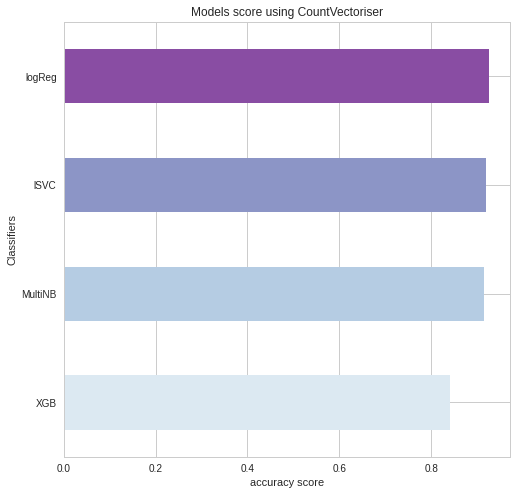

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))

# plot 
pd.DataFrame(mod_scores_vect.values(), 
             mod_scores_vect.keys(), 
             columns=['accuracy']
            ).reset_index().sort_values(by = 'accuracy').plot(x = 'index',
                                 y = 'accuracy', 
                                 ax = ax,
                                 kind = 'barh',
                                 color = colours,
                                 legend = False)

# plot infos:
plt.style.use('seaborn-whitegrid')
plt.title('Models score using CountVectoriser')
plt.ylabel('Classifiers')
plt.xlabel('accuracy score')

plt.xticks(rotation = 0);

SVM's linear SVC and LogisticRegression both achieved an acuuracy of 92%! thats sounds great.

## Hyperparameters tuning:

This is somehow, the most expensive, time and ressources consuming step of the workflow. As the vectorizers and the classification models have both tuneable parameters, and due to the small size of our sample (8650 tweets only) we use ` GridSearchCV` to select the best parameters on a 5-fold cross-validation. For compactness and practicality, and mostly since we would like to find the best parameters for both the vectorizer and the classification model, I took the liberty to do all that in a Pipeline that I saved from one of my previous projects on a GPU, something similar to [this](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html).

Here are the grid parameters that I used for tunning:

In [ ]:
## Vectorizers hyperparameters:
# BOW hyperparameters
vect_grid = {'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
             'features__pipe__vect__min_df': (1,2) }
# TF-IDF hyperparaleters
tfidf_grid = {'features__pipe__vect__analyzer' : ('word', 'char'),
              'features__pipe__vect__ngram_range': ((1, 3), (3, 7), (5, 7), (2, 2), (1, 2)),
              'features__pipe__vect__binary' : (True, False) }

## Classifiers hyperparameters:
# logReg hyperparameters
logReg_grid = {'model__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
               'model__solver': ['lbfgs', 'liblinear'],
               'model__penalty' : ('l1', 'l2')}

# MultionomialNB hyperparameters
MultiNB_grid = {'model__alpha': (0.25, 0.5, 0.75)}

# SVC hyperparameters
lSVC_grid = {'model__C': (.05, .12, .25, .5, 1, 2, 4)}

#### 1- logReg:

Using the *bag of words* approach : [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) : `vect=CountVectorizer()`

```
Best CV score: 0.933
Best parameters set:
	model__C: 100
	model__penalty: 'l2'
	model__solver: 'liblinear'
	features__pipe__vect__binary: True
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Val score with best_estimator_: 0.926

======================================================
Classification Report Test Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.92      0.93      0.92       812
        real       0.94      0.92      0.93       900
======================================================
    accuracy                           0.93      1712
   macro avg       0.93      0.93      0.93      1712
weighted avg       0.93      0.93      0.93      1712
======================================================
```

Using Term Frequency - Inverse Document Frequency : [TF - IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

```
Best CV score: 0.940
Best parameters set:
	model__C: 1000
	model__penalty: 'l2'
	model__solver: 'liblinear'
	features__pipe__vect__binary: True
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Val score with best_estimator_: 0.933

======================================================
Classification Report Test Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.94      0.92      0.93       812
        real       0.93      0.95      0.94       900
======================================================
    accuracy                           0.93      1712
   macro avg       0.93      0.93      0.93      1712
weighted avg       0.93      0.93      0.93      1712
======================================================
```

In [ ]:
vect_cstm_logReg = CountVectorizer(binary=True, max_df=0.5, min_df= 1, ngram_range=(1, 2))
logReg_vect_cstm = LogisticRegression(max_iter = 1000, C=100, penalty='l2', solver='liblinear')

tfidf_cstm_lorReg = TfidfVectorizer(binary=True, max_df=0.5, min_df=1, ngram_range=(1, 2))
logReg_tfidf_cstm = LogisticRegression(max_iter = 1000, C=1000, penalty='l2', solver='liblinear')

#### 2- MultiNB:

Using the *bag of words* approach : [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) : `vect=CountVectorizer()`

```
Best CV score: 0.927
Best parameters set:
	model__alpha: 0.25
	features__pipe__vect__binary: True
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Val score with best_estimator_: 0.928

Classification Report Val Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.94      0.90      0.92       812
        real       0.91      0.95      0.93       900
======================================================
    accuracy                           0.93      1712
   macro avg       0.93      0.93      0.93      1712
weighted avg       0.93      0.93      0.93      1712
======================================================
```

Using Term Frequency - Inverse Document Frequency : [TF - IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

```
Best CV score: 0.916
Best parameters set:
	model__alpha: 0.25
	features__pipe__vect__binary: False
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Val score with best_estimator_: 0.912

======================================================
Classification Report Test Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.94      0.87      0.90       812
        real       0.89      0.95      0.92       900
======================================================
    accuracy                           0.91      1712
   macro avg       0.91      0.91      0.91      1712
weighted avg       0.91      0.91      0.91      1712
======================================================
```

In [ ]:
vect_cstm_MultiNB = CountVectorizer(binary=True, max_df=0.25, min_df=1, ngram_range=(1, 2))
MultiNB_vect_cstm = MultinomialNB(alpha=0.25)

tfidf_cstm_MultiNB = TfidfVectorizer(binary=False, max_df=0.25, min_df=2, ngram_range=(1, 2))
MultiNB_tfidf_cstm = MultinomialNB(alpha=0.25)

#### 3- linear SVC:

Using the *bag of words* approach : [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) : `vect=CountVectorizer()`

```
Best CV score: 0.935
Best parameters set:
	model__C: 0.25
	features__pipe__vect__binary: True
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Val score with best_estimator_: 0.925

======================================================
Classification Report Test Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.91      0.93      0.92       812
        real       0.94      0.92      0.93       900
======================================================
    accuracy                           0.93      1712
   macro avg       0.92      0.93      0.93      1712
weighted avg       0.93      0.93      0.93      1712
======================================================
```

Using Term Frequency - Inverse Document Frequency : [TF - IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

```
Best CV score: 0.935
Best parameters set:
	model__C: 0.7999999999999998
	features__pipe__vect__binary: False
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 3)
Val score with best_estimator_: 0.925

======================================================
Classification Report Test Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.95      0.89      0.92       812
        real       0.90      0.96      0.93       900
======================================================
    accuracy                           0.92      1712
   macro avg       0.93      0.92      0.92      1712
weighted avg       0.93      0.92      0.92      1712
======================================================
```

In [ ]:
vect_cstm_lSVC = CountVectorizer(binary=True, max_df=0.5, min_df=1, ngram_range=(1, 2))
lSVC_vect_cstm = LinearSVC(class_weight='balanced', C=0.25)

tfidf_cstm_lSVC = TfidfVectorizer(binary=False, max_df=0.5, min_df=2, ngram_range=(1, 3))
lSVC_tfidf_cstm = LinearSVC(class_weight='balanced', C=0.7999999999999998)

#### 4- XGBoost:

Using the *bag of words* approach : [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) : `vect=CountVectorizer()`

```
Best CV score: 0.917
Best parameters set:
	model__gamma: 0
	model__learning_rate: 0.5
	model__n_estimators: 50
	model__subsample: 1.0
	features__pipe__vect__binary: True
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 3)
Val score with best_estimator_: 0.909

======================================================
Classification Report Test Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.91      0.90      0.90       812
        real       0.91      0.92      0.91       900
======================================================
    accuracy                           0.91      1712
   macro avg       0.91      0.91      0.91      1712
weighted avg       0.91      0.91      0.91      1712
======================================================
```

Using Term Frequency - Inverse Document Frequency : [TF - IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

```
Best CV score: 0.919
Best parameters set:
	model__gamma: 0.5
	model__learning_rate: 0.5
	model__n_estimators: 50
	model__subsample: 0.8
	features__pipe__vect__binary: False
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 3)
Val score with best_estimator_: 0.908

======================================================
Classification Report Test Data
======================================================
              precision    recall  f1-score   support
======================================================
        fake       0.90      0.90      0.90       812
        real       0.91      0.91      0.91       900
======================================================
    accuracy                           0.91      1712
   macro avg       0.91      0.91      0.91      1712
weighted avg       0.91      0.91      0.91      1712
======================================================
```

In [ ]:
vect_cstm_XGB = CountVectorizer(binary=True, max_df=0.25, min_df=1, ngram_range=(1, 3))
XGB_vect_cstm = XGBClassifier(use_label_encoder=False, gamma=0, learning_rate=0.5, n_estimators=50, subsample=1)

tfidf_cstm_XGB = TfidfVectorizer(binary=False, max_df=0.5, min_df=2, ngram_range=(1, 3))
XGB_tfidf_cstm = XGBClassifier(use_label_encoder=False, gamma=0.5, learning_rate=0.5, n_estimators=50, subsample=0.8)

Now we prepare set everything up

In [ ]:
models_vect_cstm = {'logReg': (logReg_vect_cstm, vect_cstm_logReg),
                    'MultiNB': (MultiNB_vect_cstm, vect_cstm_MultiNB),
                    'lSVC': (lSVC_vect_cstm, vect_cstm_lSVC),
                    'XGB': (XGB_vect_cstm, vect_cstm_XGB)}

models_tfidf_cstm = {'logReg': (logReg_tfidf_cstm, tfidf_cstm_lorReg),
                    'MultiNB': (MultiNB_tfidf_cstm, tfidf_cstm_MultiNB),
                    'lSVC': (lSVC_tfidf_cstm, tfidf_cstm_lSVC),
                    'XGB': (XGB_tfidf_cstm, tfidf_cstm_XGB) }

#tweaking the score function so it scores also using a custom vectorizer
def best_mod_score(models, X_train, X_test, y_train, y_test):
  '''
  Takes a dictionarry of models with vectorizers and fits each on a training set and returns its score on a test set
  '''
  # empty dict to append
  results = {}
  for name, tup in models.items() :
    model = tup[0]
    vect = tup[1]
    X_train_vect = vect.fit_transform(X_train.clean_tweet) # ffeature extraction:
    X_test_vect = vect.transform(X_test.clean_tweet) # transform testing data (using training data's features)
    model.fit(X_train_vect, y_train)
    results[name] = model.score(X_test_vect, y_test)
  return results

best_mod_scores_vect = best_mod_score(models_vect_cstm, X_train, X_val, y_train, y_val)
best_mod_scores_tfidf = best_mod_score(models_tfidf_cstm, X_train, X_val, y_train, y_val)

best_scores = pd.DataFrame( {'accuracy_Cvect' : ['{:.3f}%'.format(v*100) for v in best_mod_scores_vect.values()],'accuracy_TF-IDF' : ['{:.3f}%'.format(v*100) for v in best_mod_scores_tfidf.values()]}, index=models.keys()).sort_values(by='accuracy_TF-IDF', ascending = False)
best_scores

,accuracy_Cvect,accuracy_TF-IDF
logReg,93.049%,94.217%
lSVC,93.166%,94.042%
MultiNB,93.283%,91.998%
XGB,88.084%,87.266%


And visiualize how our fine tuned models performed:

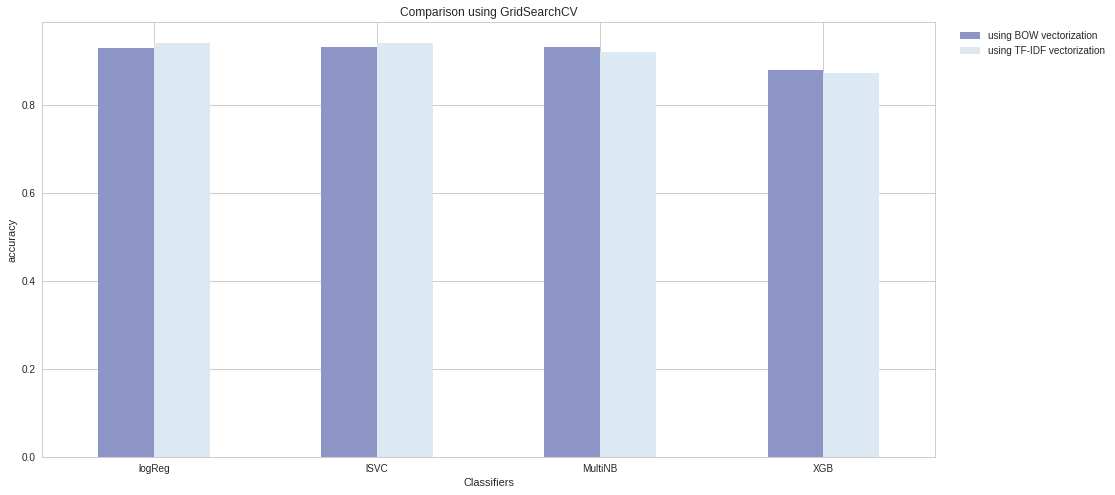

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))

#plot:
pd.DataFrame( {'accuracy_Cvect' : best_mod_scores_vect.values(), 'accuracy_TF-IDF' : best_mod_scores_tfidf.values()}, index=models.keys()).sort_values(by='accuracy_TF-IDF', ascending = False).plot.bar(color = (colours[2], colours[0]), ax = ax, legend=  False)

# plot infos:
plt.title('Comparison using GridSearchCV')
plt.xlabel('Classifiers')
plt.ylabel('accuracy')
plt.legend(['using BOW vectorization', 'using TF-IDF vectorization'], bbox_to_anchor=(1.2, 1), loc='best')
plt.xticks(rotation = 0);

# 3) Model evaluation:

Now that we saw a slight improvement in our model's performance, we can evaluate it on the testing Dataset: We first prepare our testing dataset

In [ ]:
test_df = test_df.reset_index().drop('id', axis=1)
test_df['label'] = test_df.label.map({'real':1, 'fake':0})
test_df['clean_tweet'] = test_df['tweet'].apply(clean)
test_df = test_df.drop(['tweet'], axis = 1)

And we evaluate our model on the test data:

In [ ]:
X_train, X_test, y_train, y_test = main_df.drop(['label'], axis=1), test_df.drop(['label'], axis=1), main_df.label, test_df.label

# Preprocess and Vectorize the data:
X_train_tfidfv = tfidf_cstm_lorReg.fit_transform(X_train.clean_tweet)
X_test_tfidfv = tfidf_cstm_lorReg.transform(X_test.clean_tweet)

# Instantiate best model with best hyperparameters
history = logReg_tfidf_cstm.fit(X_train_tfidfv, y_train)

# Make predictions
y_preds = history.predict(X_test_tfidfv)

### Confusion matrix:

It is somehow a visual way to show where our model nailed its predictions and where it failed:

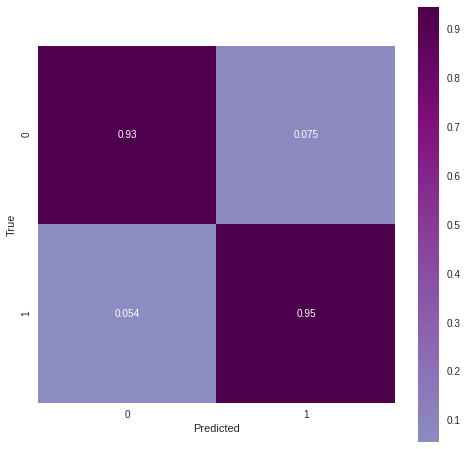

In [ ]:
conf_mtrx = confusion_matrix(y_test, y_preds)

conf_mtrx_plot(conf_mtrx, normalize=True);

### ROC Curve and AUC Scores

We basically compare the true positive rate to the false positive rate, i.e. a tweet that is flagged real, but is fake vs a tweet that is flagged fake although it is real:

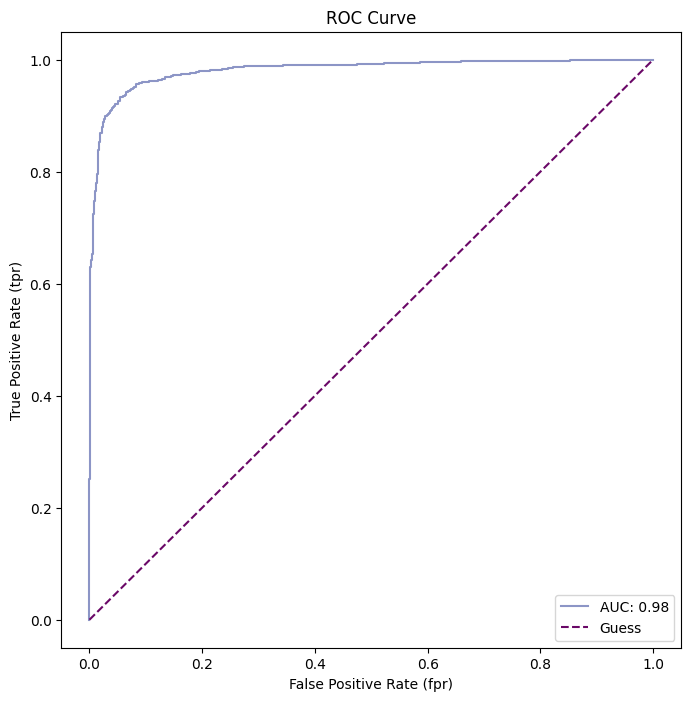

In [ ]:
ROC_cur_plot(history, X_test_tfidfv, y_test);

### Classification report:
Now let's have a look at the main evaluation metrics:

In [ ]:
# Create a classification report using the classification_report function
report = classification_report(y_test, y_preds, output_dict=True)

pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.939303,0.925490,0.932346,1020.000000
1,0.933040,0.945536,0.939246,1120.000000
accuracy,0.935981,0.935981,0.935981,0.935981
macro avg,0.936172,0.935513,0.935796,2140.000000
weighted avg,0.936025,0.935981,0.935957,2140.000000


We can try our model out, with some random made up tweets and see how it performs :

In [ ]:
tweet1 = """The charity @TEDSliverpool says money raised in memory of Claudia Walsh 
means it'll be able to help more people with mental health issuesClaudia died with 
#coronoavirus on her 25th birthday. She also volunteered at @WhitechapelLiv. More 
than £21,000 has already been raised"""

tweet2 = """Canadian-made SARS-CoV-2 detector set to ship worldwide | $KNR $KNR.ca 
#biocloud #smartbuildings #smartfactory #kontrol #smartcity #smartcities  #ontario 
#canada #safespaces #madeincanada #innovation #ai #iot #covid19 #covidー19 #sarscov2 
#coronoavirus https://bit.ly/3mXWV2O"""

tweet3 = """#Coronoavirus : "Indigenous people are stepping up as volunteer firefighters, 
but they are now doubly strained: Closed borders have shriveled their income from sustainably 
harvested forest exports" @ACOFOP #Guatemala @alianzabosques https://apnews.com/e3cddd53e453a2"""

tweet4 = """Masih Alinejad says Government hid news of #coronoavirus for political purposes"""

df = pd.DataFrame([tweet1, tweet2, tweet3, tweet4], columns=['tweet'])
df['clean_tweet'] = df['tweet'].apply(clean)
df = df.drop(['tweet'], axis = 1)
vect = tfidf_cstm_lorReg.transform(df.clean_tweet)

and we can use our model to predict the veracity of tweets:

In [ ]:
# Make predictions
y_preds = ['real' if v == 1 else 'fake' for v in history.predict(vect).tolist() ]

y_preds

['fake', 'real', 'fake', 'fake']

# 4) For the future:

Maybe try Deep Learning? a CNN using Words Embeddings with LogReg's feature extractions... or robert/daBert? Ernie2.0?